In [5]:
import numpy as np
from numpy import inf
from numpy import nan

import math
from scipy.optimize import differential_evolution
from scipy.stats import entropy

import time

import multiprocessing as mp
from pylab import rcParams

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
from matplotlib.ticker import FormatStrFormatter
from mpl_toolkits import mplot3d
import matplotlib.colors as mcolors
%matplotlib inline 

import utils

### parameters

In [6]:
popSize = 500 # population size
n =5 # group size for individual interactions

mu = 0.1 # mutation rate
sigma=0.005 #mutation size



In [7]:
b2 = -6 # quadratic benefit coefficient for task X
beta =3 # slope of benefit for task Y (eg. brood care)
alpha = 1.5 # selection intensity in social learning

In [8]:
#initial traits
x=0.5 
y=0.5

## Total Benefit Accrue to Individuals Inside a Game

In [9]:
from utils import benefit

### Cost of Task X

In [10]:
from utils import cost_X

### Cost of Task Y

In [11]:
from utils import cost_Y

## Total Cost For an Individual

In [12]:
from utils import cost

## Payoff Array of the Individuals Inside a Game

In [13]:
from utils import payoffGame

## Mutations

In [14]:
from utils import mutate_xy, only_trait1_mutation, only_trait2_mutation, both_traits_mutation 

## One Round Gameplay in Population

In [15]:
from utils import oneRound

## Iterative Game Playing

In [16]:
from utils import play

## Traits Dynamic Plotting

In [17]:
def getZeroStreaks(L,minSize=2):
    '''
    The function receives a 1-D binary array and finds all [start,end] indice pairs for all consecutive 'zero' sequences with
    length more than "minSize"
    params:
    L: 1-D binary numpy array
    minSize: minimum length of the 'zero sequence'to detect
    '''
    breaks = [i for i,(a,b) in enumerate(zip(L,L[1:]),1) if a!=b]
    return [[s,e-1] for s,e in zip([0]+breaks,breaks+[len(L)])
                        if e-s>=minSize and not L[s]]


In [64]:
def plotEvolutions(tEnd, plotInterval,b1,w,alpha):

    global x_binned_all
    global y_binned_all
    global z_binned_all

    popSize = utils.popSize
    all_x_traits = utils.all_x_traits
    all_y_traits = utils.all_y_traits
    all_z_traits = utils.all_z_traits
    all_ids = utils.all_ids
    
    

    ## Binarize all  trait value vectors (x,y,z) at each time step of the simulation using the defined bin_size
    bin_size = 0.06
    bins = np.arange(0,1+bin_size,bin_size)
    ceiling = len(bins) -2
    x_binned_all = []
    y_binned_all = []
    z_binned_all = []
    
    for steps in range(tEnd//plotInterval):
        x_binned = []
        y_binned = []
        z_binned = []
        for interval in range(len(bins)-1):
            if (np.logical_and(all_x_traits[steps] > bins[interval], all_x_traits[steps] <= bins[interval+1]).any()):
                x_binned.append(1)
            else:
                x_binned.append(0)
                
            if (np.logical_and(all_y_traits[steps] > bins[interval], all_y_traits[steps] <= bins[interval+1]).any()):
                y_binned.append(1)
            else:
                y_binned.append(0)
            
            if (np.logical_and(all_z_traits[steps] > bins[interval], all_z_traits[steps] <= bins[interval+1]).any()):
                z_binned.append(1)
            else:
                z_binned.append(0)
        
        x_binned_all.append(x_binned) 
        y_binned_all.append(y_binned)    
        z_binned_all.append(z_binned)  
        
    
    ## Identify all 'zero' sequences with length more or equal to minSize = 2 using the getZeroStreaks function.
    # These will be gaps larger than minSize * bin_size (2 *0.06) in the vector of each trait value at each time step
    # Disregard sequences which start/end with the floor or ceiling bin indices 
    # (the gaps between the trait values and 0 or trait values and 1 are not indicative of the branching phenomenon)
    # x/y/z_id1: The index where branching starts, x/y/z_id2: The index where branching ends
    # branch_t_x/branch_t_y/branch_t_z: The time point when the branching in x/y/z first occurs. 
    
    x_id1 = []
    x_id2 =[]
    branch_t_x = []
    flag =0

    for steps in range(tEnd//plotInterval):
        if flag:
            break
        for i in range(len(getZeroStreaks(x_binned_all[steps]))):
            if 0 in list(getZeroStreaks(x_binned_all[steps])[i]):
                pass
            elif ceiling in list(getZeroStreaks(x_binned_all[steps])[i]):
                pass
            elif len(getZeroStreaks(x_binned_all[steps]))>0:
                x_id1 = getZeroStreaks(x_binned_all[steps])[i][0]
                x_id2 = getZeroStreaks(x_binned_all[steps])[i][1]
                flag = 1
                branch_t_x = steps*plotInterval
                break 


    y_id1 = []
    y_id2 =[]
    branch_t_y = []
    flag =0

    for steps in range(tEnd//plotInterval):
        if flag:
            break
        for i in range(len(getZeroStreaks(y_binned_all[steps]))):
            if 0 in list(getZeroStreaks(y_binned_all[steps])[i]):
                pass
            elif ceiling in list(getZeroStreaks(y_binned_all[steps])[i]):
                pass
            else:
                y_id1 = getZeroStreaks(y_binned_all[steps])[i][0]
                y_id2 = getZeroStreaks(y_binned_all[steps])[i][1]
                flag = 1
                branch_t_y = steps*plotInterval
                break 



    z_id1 = []
    z_id2 =[]
    branch_t_z =[]
    flag =0

    for steps in range(tEnd//plotInterval):
        if flag:
            break
        for i in range(len(getZeroStreaks(z_binned_all[steps]))):
            if 0 in list(getZeroStreaks(z_binned_all[steps])[i]):
                pass
            elif ceiling in list(getZeroStreaks(z_binned_all[steps])[i]):
                pass
            else:
                z_id1 = getZeroStreaks(z_binned_all[steps])[i][0]
                z_id2 = getZeroStreaks(z_binned_all[steps])[i][1]
                flag = 1
                branch_t_z = steps*plotInterval
                break 


    ## Map the identified indices for the start of each gap (zero sequence longer than 2), to the value of 
    # the corresponding trait. This value would be used as a threhold to differentiate colors of branches above 
    # or below the threshold
    if (x_id1 and y_id1 and z_id1):
        color_x_start1 = x_id1 *bin_size
        color_y_start1 = y_id1 *bin_size
        color_z_start1 = z_id1 *bin_size
        
    
    ## branch_T: branching point (in time) is the maximum time point where one of the trait values branch
    branch_T = []
    if (branch_t_x and branch_t_y and branch_t_z):
        branch_T = max(branch_t_x,branch_t_y,branch_t_z)
 

    ## Define 't' and 'trait' vectors for the plot
    t = np.array([ np.full(popSize,i*plotInterval) for i in range(1,1+tEnd//plotInterval) ]).flatten()
    x = np.array(all_x_traits).flatten()
    y=np.array(all_y_traits).flatten()
    ids= np.array(all_ids).flatten()

   

    
    plt.rcParams["font.family"] = "sans-serif"
    font = FontProperties()
    
        
  ##############################################################################################################    
    fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,4))
    if branch_T:
        
        ## Separate the plot before and after the global branching point
        branch_t_x = branch_T
        x_after = x[t>branch_t_x]
        t_after = t[t>branch_t_x]
        
        ## Identify individual indices that are above the coloring threshold after the branching point
        # Assign different colors to individuals below and above this threshold.
        # Note that the same indices will be used across all subplots (all trait values) to define the color
        # of the individuals in all time points after the branching point
        x_after_up = x_after>(color_x_start1)
        
        ax1.scatter(t_after[~x_after_up], x_after[~x_after_up],s=0.5, color='#FFD700')
        ax1.scatter(t_after[x_after_up], x_after[x_after_up],s=0.5, color='#104E8B')
        ax1.plot(t[t<branch_t_x], x[t<branch_t_x], '.',color='mediumvioletred', markersize=0.1, alpha = 1, label = 'x')
        legend = ax1.legend(bbox_to_anchor=(0.3, 0.94, 1., .102),markerscale=240, shadow=True,prop={'size':14,'weight':'bold'})
        
    else:
        ax1.plot(t, x, '.',color='mediumvioletred', markersize=0.1, alpha = 1, label = 'x')
        legend = ax1.legend(bbox_to_anchor=(0.3, 0.94, 1., .102),markerscale=240, shadow=True,prop={'size':14,'weight':'bold'})
        
        
        
    ax1.set_xlabel('time', fontsize=16,fontweight="bold")
    ax1.set_ylabel('x', fontsize=16,fontweight="bold")
    
    fontproperties = {'weight' : 'bold', 'size' : 12}
    ax1.set_xticklabels(ax1.get_xticks(), fontproperties)
    ax1.set_yticklabels(ax1.get_yticks(), fontproperties)
    ax1.yaxis.set_major_formatter(FormatStrFormatter("%.1f"))
    ax1.xaxis.set_major_formatter(FormatStrFormatter("%d"))
    ax1.margins(0)

    legend = ax1.legend(bbox_to_anchor=(0.3, 0.94, 1., .102),markerscale=240, shadow=True,prop={'size':14,'weight':'bold'})
    ax1.set_xlabel('time', fontsize=16,fontweight="bold")
    ax1.set_ylabel('x', fontsize=16,fontweight="bold")
    ax1.get_legend().remove()
    ax1.set_ylim([0, 1])

    
    plt.ylim((0,1))
    plt.grid(False)  
    
    
    ############ No colouring#############
    
#     fig, ax = plt.subplots()
    ax2.plot(t, x, '.', color='mediumvioletred', markersize=0.05,label='x')
    legend = ax2.legend(bbox_to_anchor=(0.3, 0.94, 1., .102),markerscale=240, shadow=True,prop={'size':14,'weight':'bold'})
    ax2.set_xlabel('time', fontsize=16,fontweight="bold")
    ax2.set_ylabel('x', fontsize=16,fontweight="bold")
    ax2.set_title('Without coloring branches')
    
    fontproperties = {'weight' : 'bold', 'size' : 12}
    ax2.set_xticklabels(ax2.get_xticks(), fontproperties)
    ax2.set_yticklabels(ax2.get_yticks(), fontproperties)
    ax2.yaxis.set_major_formatter(FormatStrFormatter("%.1f"))
    ax2.xaxis.set_major_formatter(FormatStrFormatter("%d"))
    ax2.margins(0)

    plt.ylim((0,1))
    plt.grid(False)
    plt.show()
    
    
    
  ##############################################################################################################    
    fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,4))
    if branch_T:
        branch_t_y = branch_T
        y_after = y[t>branch_t_y]
        t_after = t[t>branch_t_y]
        
        y_after_up = y_after>(color_y_start1)
        ax1.scatter(t_after[~x_after_up], y_after[~x_after_up],s=0.5, color='#FFD700')
        ax1.scatter(t_after[x_after_up], y_after[x_after_up],s=0.5, color='#104E8B')
        ax1.plot(t[t<branch_t_y], y[t<branch_t_y], '.',color='seagreen', markersize=0.1, alpha = 1, label = 'y')
        legend = ax1.legend(bbox_to_anchor=(0.3, 0.94, 1., .102),markerscale=240, shadow=True,prop={'size':14,'weight':'bold'})

    else:
        ax1.plot(t, y, '.',color='seagreen', markersize=0.1, alpha = 1, label = 'y')
        legend = ax1.legend(bbox_to_anchor=(0.3, 0.94, 1., .102),markerscale=240, shadow=True,prop={'size':14,'weight':'bold'})

    
    ax1.set_xlabel('time', fontsize=16,fontweight="bold")
    ax1.set_ylabel('y', fontsize=16,fontweight="bold")
    
    fontproperties = {'weight' : 'bold', 'size' : 12}
    ax1.set_xticklabels(ax1.get_xticks(), fontproperties)
    ax1.set_yticklabels(ax1.get_yticks(), fontproperties)
    ax1.yaxis.set_major_formatter(FormatStrFormatter("%.1f"))
    ax1.xaxis.set_major_formatter(FormatStrFormatter("%d"))
    ax1.margins(0)

      
    legend = ax1.legend(bbox_to_anchor=(0.3, 0.94, 1., .102),markerscale=240, shadow=True,prop={'size':14,'weight':'bold'})
    ax1.set_xlabel('time', fontsize=16,fontweight="bold")
    ax1.set_ylabel('y', fontsize=16,fontweight="bold")
    
    fontproperties = {'weight' : 'bold', 'size' : 12}
    ax1.set_xticklabels(ax1.get_xticks(), fontproperties)
    ax1.set_yticklabels(ax1.get_yticks(), fontproperties)
    ax1.yaxis.set_major_formatter(FormatStrFormatter("%.1f"))
    ax1.xaxis.set_major_formatter(FormatStrFormatter("%d"))
    ax1.margins(0)
    ax1.set_ylim([0, 1])
    ax1.get_legend().remove()

    plt.ylim((0,1))
    plt.grid(False)    
# 
    
    
    ############ No colouring#############
#     fig, ax = plt.subplots()
    ax2.plot(t, y, '.',color='seagreen', markersize=0.05,label='y')
    
    legend = ax2.legend(bbox_to_anchor=(0.3, 0.94, 1., .102),markerscale=240, shadow=True,prop={'size':14,'weight':'bold'})
    ax2.set_xlabel('time', fontsize=16,fontweight="bold")
    ax2.set_ylabel('y', fontsize=16,fontweight="bold")
    ax2.set_title('Without coloring branches')
    
    fontproperties = {'weight' : 'bold', 'size' : 12}
    ax2.set_xticklabels(ax2.get_xticks(), fontproperties)
    ax2.set_yticklabels(ax2.get_yticks(), fontproperties)
    ax2.yaxis.set_major_formatter(FormatStrFormatter("%.1f"))
    ax2.xaxis.set_major_formatter(FormatStrFormatter("%d"))
    ax2.margins(0)

    plt.ylim((0,1))
    plt.grid(False)    
    plt.show()


    
 ##############################################################################################################    
    fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,4))
    if branch_T:
        branch_t_z = branch_T
        z = 1-x-y
        z_after = z[t>branch_t_z]
        t_after = t[t>branch_t_z]
        
        z_after_up = z_after>(color_z_start1)
        ax1.scatter(t_after[~x_after_up], z_after[~x_after_up],s=0.5, color='#FFD700')
        ax1.scatter(t_after[x_after_up], z_after[x_after_up],s=0.5, color='#104E8B')
        ax1.plot(t[t<branch_t_z], z[t<branch_t_z], '.',color='midnightblue', markersize=0.1, alpha = 1, label = 'z')
        legend = ax1.legend(bbox_to_anchor=(0.3, 0.94, 1., .102),markerscale=240, shadow=True,prop={'size':14,'weight':'bold'})

    else:
        ax1.plot(t, 1-x-y, '.',color='midnightblue', markersize=0.1, alpha = 1, label = 'z')
        legend = ax1.legend(bbox_to_anchor=(0.3, 0.94, 1., .102),markerscale=240, shadow=True,prop={'size':14,'weight':'bold'})

    ax1.set_xlabel('time', fontsize=16,fontweight="bold")
    ax1.set_ylabel('z', fontsize=16,fontweight="bold")
    
    fontproperties = {'weight' : 'bold', 'size' : 12}
    ax1.set_xticklabels(ax1.get_xticks(), fontproperties)
    ax1.set_yticklabels(ax1.get_yticks(), fontproperties)
    ax1.yaxis.set_major_formatter(FormatStrFormatter("%.1f"))
    ax1.xaxis.set_major_formatter(FormatStrFormatter("%d"))
    ax1.margins(0)

    legend = ax1.legend(bbox_to_anchor=(0.3, 0.94, 1., .102),markerscale=240, shadow=True,prop={'size':14,'weight':'bold'})
    ax1.set_xlabel('time', fontsize=16,fontweight="bold")
    ax1.set_ylabel('z', fontsize=16,fontweight="bold")
    
    fontproperties = {'weight' : 'bold', 'size' : 12}
    ax1.set_xticklabels(ax1.get_xticks(), fontproperties)
    ax1.set_yticklabels(ax1.get_yticks(), fontproperties)
    ax1.yaxis.set_major_formatter(FormatStrFormatter("%.1f"))
    ax1.xaxis.set_major_formatter(FormatStrFormatter("%d"))
    ax1.margins(0)
    ax1.set_ylim([0, 1])
    ax1.get_legend().remove()

    plt.ylim((0,1))
    plt.grid(False) 

    
    
    
    ############ No colouring#############
    
#     fig, ax = plt.subplots()
    ax2.plot(t, 1-x-y, '.',color='midnightblue',markersize=0.05, label='z')
    legend = ax2.legend(bbox_to_anchor=(0.3, 0.94, 1., .102),markerscale=240, shadow=True,prop={'size':14,'weight':'bold'})
    ax2.set_xlabel('time', fontsize=16,fontweight="bold")
    ax2.set_ylabel('z', fontsize=16,fontweight="bold")
    ax2.set_title('Without coloring branches')
    
    fontproperties = {'weight' : 'bold', 'size' : 12}
    ax2.set_xticklabels(ax2.get_xticks(), fontproperties)
    ax2.set_yticklabels(ax2.get_yticks(), fontproperties)
    ax2.yaxis.set_major_formatter(FormatStrFormatter("%.1f"))
    ax2.xaxis.set_major_formatter(FormatStrFormatter("%d"))
    ax2.margins(0)

    plt.ylim((0,1))
    plt.grid(False) 
    plt.show()


## Run function

In [65]:
def run(startTrait, tEnd, plotInterval,b1,w,alpha):
    start = time.time() # should use process_time but only available in Python 3.3 and up 
    play(startTrait, tEnd, plotInterval,b1,w,alpha)
    end = time.time() 
    print(end - start)
    plotEvolutions(tEnd, plotInterval,b1,w,alpha)
    return

## Simulation Results for T=30000

### For b2 = -6

### Random sampling inside an area of branching region

22.140965008896316
0.2725429432106351
281.59151697158813


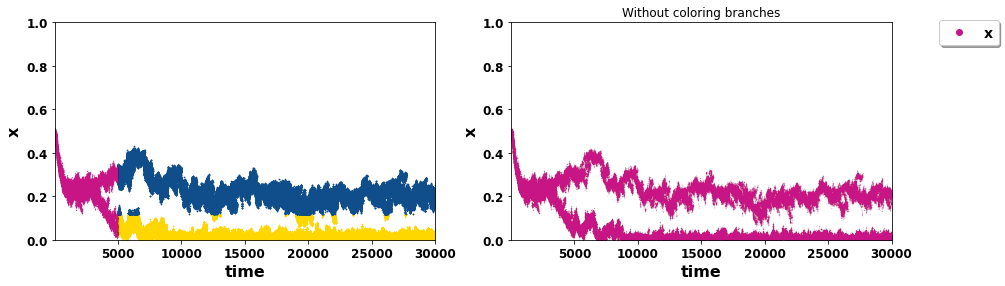

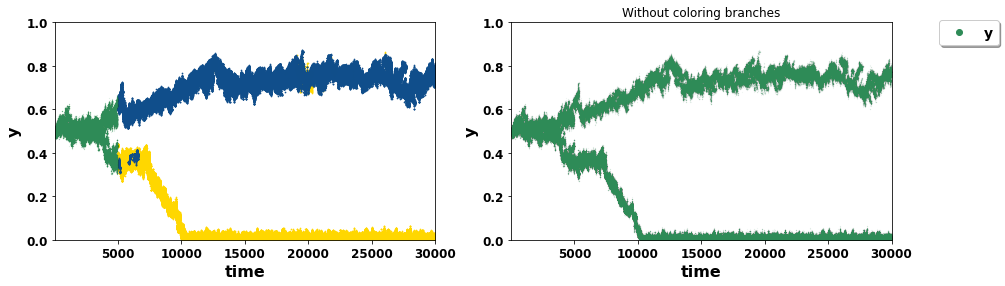

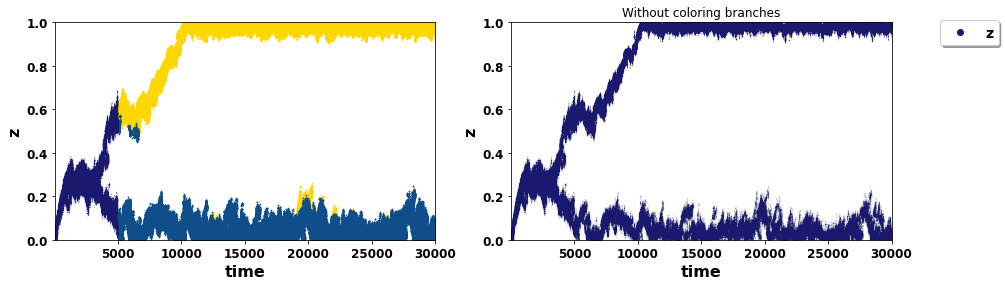

In [68]:
b = np.random.uniform(21.5, 23)
w = np.random.uniform(0.25, 0.3)
print(b)
print(w)

x=0.5
y=0.5
run([x,y],30000,10,b,w,1.5)

22.496862092451487
0.28094008037124224
336.7186620235443


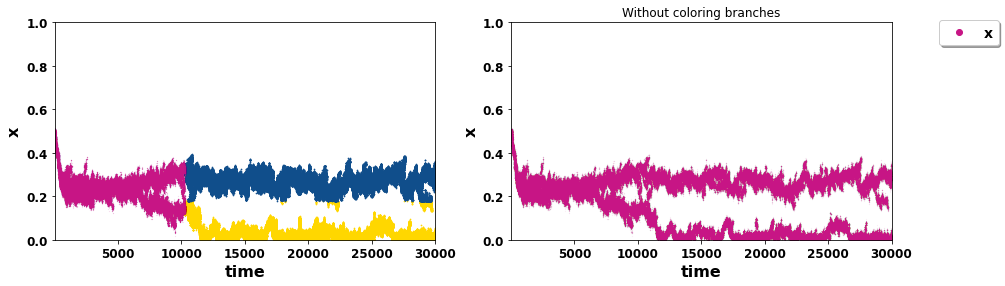

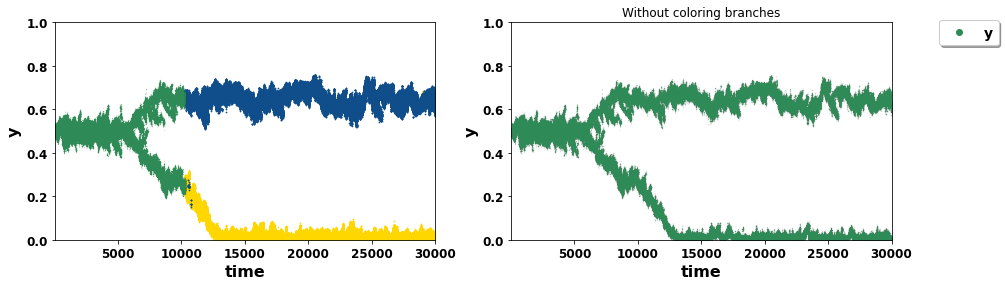

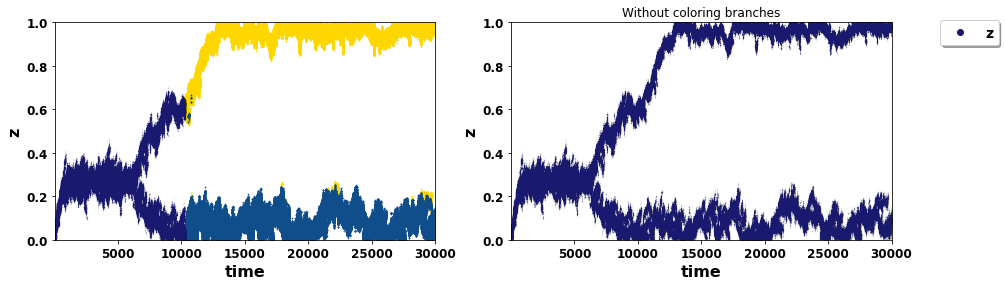

In [71]:
b = np.random.uniform(21.5, 23)
w = np.random.uniform(0.25, 0.3)
print(b)
print(w)

x=0.5
y=0.5
run([x,y],30000,10,b,w,1.5)

## Sample run in the branching region for longer T

/Users/mkha0093/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.


871.8652029037476


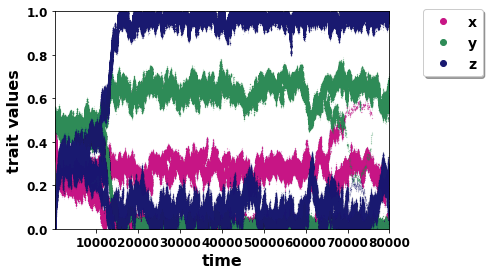

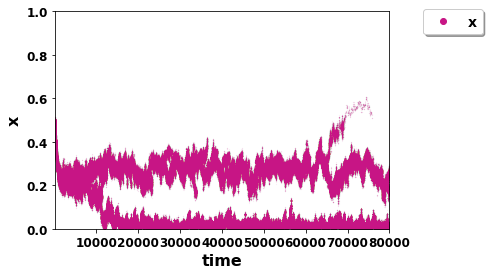

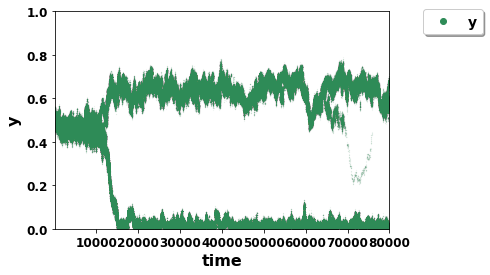

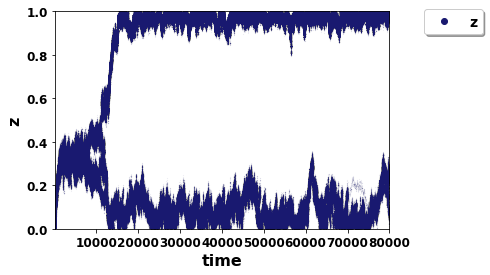

34.46615357404987

In [34]:
x=0.5
y=0.5
run([[x,y]],80000,10,22,0.3,1.5)